In [1]:
!pip3 install grid2op[optional]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 77.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 39.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 38.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 73.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.8/853.8 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 2.7 MB/s eta 0:00:00
  Created wheel for pandapower: filename=pandapower-2.14.11-py3-none-any.whl size=13131025 sha256=a7806655ae1f74719ae7c7adde0582153acff4a0b5463f9cea737cd9f4b0ccda
  Stored in directory: /root/.cache/pip/wheels/7f/de/5a/7b00f385eb06d1fb1f7c1cd06f9bb901709c038d3899548cf1
  Created wheel for pygifsicle: filename=pygifsicle-1.1

In [3]:
!git clone https://github.com/grid2op/Grid2Op.git
!cd Grid2Op
!pip3 install -U .
!cd ..

fatal: destination path 'Grid2Op' already exists and is not an empty directory.
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [4]:
!pip install wandb
!pip install stable_baselines3

In [6]:
import gymnasium as gym

import grid2op
import copy
from typing import Dict, Literal, Any, OrderedDict, Optional, Tuple, Union
from grid2op import gym_compat
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from grid2op.Reward import L2RPNReward, N1Reward, CombinedScaledReward, LinesCapacityReward, LinesReconnectedReward, CloseToOverflowReward , AlertReward
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from gymnasium.spaces import Discrete, MultiDiscrete, Box
from grid2op.gym_compat import GymEnv, BoxGymObsSpace, DiscreteActSpace, BoxGymActSpace, MultiDiscreteActSpace, ContinuousToDiscreteConverter
from gymnasium import spaces
from lightsim2grid import LightSimBackend
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
import wandb
from wandb.integration.sb3 import WandbCallback
import numpy as np
from stable_baselines3 import DQN, HerReplayBuffer
from stable_baselines3.common.buffers import ReplayBuffer
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy # 'final', 'episode', 'future'
import matplotlib.pyplot as plt
from stable_baselines3.common.evaluation import evaluate_policy

In [7]:
# Gymnasium environment wrapper around Grid2Op environment
class Gym2OpEnvWrapper(gym.Env):
    def __init__(
            self,env_config: Dict[Literal["backend_cls",
                                          "backend_options",
                                          "env_name",
                                          "env_is_test",
                                          "obs_attr_to_keep",
                                          "act_type",
                                          "act_attr_to_keep"],
                                  Any] = None,reward_class=CombinedScaledReward, other_rewards = {}, use_rewards=True, baseline=True):
        super().__init__()
        if env_config is None:
            self.env_config = {}
        else:
            self.env_config=env_config

        backend_cls = LightSimBackend
        if "backend_cls" in self.env_config:
            backend_cls = self.env_config["backend_cls"]
        backend_options = {}
        if "backend_options" in self.env_config:
            backend_options = self.env_config["backend_options"]
        self._backend = backend_cls(**backend_options)

        #self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"  # DO NOT CHANGE
        self.baseline = baseline
        action_class = PlayableAction
        observation_class = CompleteObservation
        self.reward_class = reward_class # Setup further below
        self.other_rewards = other_rewards

        # DO NOT CHANGE Parameters
        # See https://grid2op.readthedocs.io/en/latest/parameters.html
        p = Parameters()
        p.MAX_SUB_CHANGED = 4  # Up to 4 substations can be reconfigured each timestep
        p.MAX_LINE_STATUS_CHANGED = 4  # Up to 4 powerline statuses can be changed each timestep

        if use_rewards:
            # Make grid2op env
            self._g2op_env = grid2op.make(
                self._env_name, backend=self._backend, test=False,
                action_class=action_class, observation_class=observation_class,
                reward_class=self.reward_class, param=p, other_rewards=self.other_rewards
            )

        ##########
        # REWARD #
        ##########
        # NOTE: This reward should not be modified when evaluating RL agent
        # See https://grid2op.readthedocs.io/en/latest/reward.html
        else:
            self._g2op_env = grid2op.make(
                self._env_name, backend=self._backend, test=False,
                action_class=action_class, observation_class=observation_class,
                reward_class=self.reward_class, param=p
            )

        cr = self._g2op_env.get_reward_instance()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        #reward = N1 + L2RPN
        cr.initialize(self._g2op_env)
        ##########

        self._gym_env = gym_compat.GymEnv(self._g2op_env)

        self.setup_observations()
        self.setup_actions()

        self.observation_space = self.setup_observations()
        self.action_space = self.setup_actions()

    def setup_observations(self):
        #print("WARNING: setup_actions is not doing anything. Implement your own code in this method.")

        if self.baseline:
            self._gym_env.observation_space.close()
            self._gym_env.observation_space = BoxGymObsSpace(self._g2op_env.observation_space)
            return Box(shape=self._gym_env.observation_space.shape,
                                     low=self._gym_env.observation_space.low,
                                     high=self._gym_env.observation_space.high)

        obs_attr_to_keep = ["rho", "p_or", "gen_p", "load_p"]
        if "obs_attr_to_keep" in self.env_config:
            obs_attr_to_keep = copy.deepcopy(self.env_config["obs_attr_to_keep"])
        self._gym_env.observation_space.close()
        self._gym_env.observation_space = BoxGymObsSpace(self._g2op_env.observation_space,
                                                         attr_to_keep=obs_attr_to_keep
                                                         )
        # export observation space for the Grid2opEnv
        observation_space = Box(shape=self._gym_env.observation_space.shape,
                                     low=self._gym_env.observation_space.low,
                                     high=self._gym_env.observation_space.high)
        return observation_space

    def setup_actions(self):
        # TODO: Your code to specify & modify the action space goes here
        # See Grid2Op 'getting started' notebooks for guidance
        #  - Notebooks: https://github.com/rte-france/Grid2Op/tree/master/getting_started
        #print("WARNING: setup_actions is not doing anything. Implement your own code in this method.")

        act_type = "discrete"
        if "discrete" in self.env_config:
            act_type = self.env_config["act_type"]

        self._gym_env.action_space.close()
        if act_type == "discrete" and not self.baseline:
            # user wants a discrete action space
            act_attr_to_keep =  ["set_line_status","redispatch","set_bus"]
            if "act_attr_to_keep" in self.env_config:
                act_attr_to_keep = copy.deepcopy(self.env_config["act_attr_to_keep"])
            self._gym_env.action_space = DiscreteActSpace(self._g2op_env.action_space,
                                                          attr_to_keep=act_attr_to_keep)
            action_space = Discrete(self._gym_env.action_space.n)
        else:
            self._gym_env.action_space = DiscreteActSpace(self._g2op_env.action_space)
                                                        
            action_space = Discrete(self._gym_env.action_space.n)

        
        return action_space

    def reset(self, seed=None):
        return self._gym_env.reset(seed=seed, options=None)

    def step(self, action):
        return self._gym_env.step(action)

    def render(self):
        # TODO: Modify for your own required usage
        return self._gym_env.render()


## DQN agent interacting in environment

## Baseline Model

In [8]:
config = {
    "policy_type": "MlpPolicy",
    "total_timesteps": 10000,
    "env_name": "l2rpn_case14_sandbox",
}
run = wandb.init(
    project="RL_Final",
    config=config,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)


def make_env():
    env = Gym2OpEnvWrapper(use_rewards=False)
    env = Monitor(env)  # record stats such as returns
    return env


env = DummyVecEnv([make_env])
# env = VecVideoRecorder(
#     env,
#     f"videos/{run.id}",
#     record_video_trigger=lambda x: x % 2000 == 0,
#     video_length=200,
# )
model_baseline = DQN(config["policy_type"], env, verbose=1, tensorboard_log=f"runs/{run.id}", target_update_interval=0, gradient_steps=1)
model_baseline.learn(
    total_timesteps=config["total_timesteps"],
    callback=WandbCallback(
        gradient_save_freq=1,
        model_save_path=f"DQN_Final/{run.id}",
        verbose=1,
    ),
)
run.finish()
env.close()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/grid2op/MakeEnv/Make.py:506: UserWarning: It is the first time you use the environment "l2rpn_case14_sandbox".
We will attempt to download this environment from remote
  warnings.warn(_MAKE_FIRST_TIME_WARN.format(dataset_name))


downloading the training data, this may take a while.


l2rpn_case14_sandbox.tar.bz2: 294MB [00:20, 14.7MB/s]                              


Extract the tar archive in "/root/data_grid2op"
	 Successfully updated file "config.py" for environment "l2rpn_case14_sandbox"
	 Successfully updated file "grid.json" for environment "l2rpn_case14_sandbox"
You may now use the environment "l2rpn_case14_sandbox" with the available data by invoking:
	env = grid2op.make("l2rpn_case14_sandbox")


/opt/conda/lib/python3.10/site-packages/grid2op/gym_compat/discrete_gym_actspace.py:260: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "curtail" when building it, be aware that this continuous action will be treated as discrete by splitting it into bins. Consider using the "BoxGymActSpace" for these attributes.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/grid2op/gym_compat/discrete_gym_actspace.py:260: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "redispatch" when building it, be aware that this continuous action will be treated as discrete by splitting it into bins. Consider using the "BoxGymActSpace" for these attributes.
  warnings.warn(


Using cuda device
Logging to runs/e3yffbh2/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.75     |
|    ep_rew_mean      | -0.0937  |
|    exploration_rate | 0.99     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 11       |
|    time_elapsed     | 0        |
|    total_timesteps  | 11       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.38     |
|    ep_rew_mean      | -0.174   |
|    exploration_rate | 0.982    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 11       |
|    time_elapsed     | 1        |
|    total_timesteps  | 19       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3        |
|    ep_rew_mean      | -0.0481  |
|    exploration_rate | 0.966    |
| time

global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇█████
rollout/ep_len_mean,▇▆▆▆▆▆▆▄▅▅▆▄▁▄█▅▅▃▄▄▄▅▆▂▂▅▇█▇▇▃▄▅▄▄▃▃▆▆▄
rollout/ep_rew_mean,▆▅▄▄▅▄▅▄▂▁▅▅▃▃▄▃▂▅▅▅▃▄▄▃▂▃▄▄▄▅▂▃▃▄▆▃▅▇█▄
rollout/exploration_rate,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/fps,▁██████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
global_step,9985
rollout/ep_len_mean,3.25
rollout/ep_rew_mean,0.05277
rollout/exploration_rate,0.05
time/fps,20


In [44]:
env = Gym2OpEnvWrapper(use_rewards=False)
evaluate_policy(model_baseline, env, n_eval_episodes=200, render=False)


/opt/conda/lib/python3.10/site-packages/grid2op/gym_compat/discrete_gym_actspace.py:260: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "redispatch" when building it, be aware that this continuous action will be treated as discrete by splitting it into bins. Consider using the "BoxGymActSpace" for these attributes.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/grid2op/gym_compat/discrete_gym_actspace.py:260: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "curtail" when building it, be aware that this continuous action will be treated as discrete by splitting it into bins. Consider using the "BoxGymActSpace" for these attributes.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 

(77.33673375677317, 63.211407379975824)

In [45]:
env.close()

In [14]:
def evaluate_and_plot(model, model_name, eval_env, periods=[5, 20, 100, 200, 300]):
    """
    Evaluate model over different numbers of episodes and plot results
    
    Args:
        model: The trained model to evaluate
        eval_env: The evaluation environment
        periods: List of episodes to evaluate over
    """
    mean_rewards = []
    std_rewards = []
    
    # Evaluate for each period
    for n_episodes in periods:
        mean_reward, std_reward = evaluate_policy(
            model,
            eval_env,
            n_eval_episodes=n_episodes,
            deterministic=True
        )
        mean_rewards.append(mean_reward)
        std_rewards.append(std_reward)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.errorbar(periods, mean_rewards, yerr=std_rewards, 
                fmt='o-', capsize=5, capthick=1, elinewidth=1)
    
    plt.xlabel('Number of Episodes')
    plt.ylabel('Mean Reward')
    plt.title(f'{model_name} Model Performance Over Different Evaluation Periods')
    plt.grid(True)
    
    # Print numerical results
    for period, mean, std in zip(periods, mean_rewards, std_rewards):
        print(f"Episodes: {period}, Mean: {mean:.2f}, Std: {std:.2f}")
    
    plt.show()
    
    return mean_rewards, std_rewards

## You can predifine your own periods and evaluate it over multiple periods, it also includes error bars

Episodes: 5, Mean: -0.50, Std: 0.00
Episodes: 20, Mean: 3.81, Std: 18.62
Episodes: 100, Mean: 3.20, Std: 16.44
Episodes: 200, Mean: 2.04, Std: 13.50
Episodes: 300, Mean: 1.68, Std: 13.04


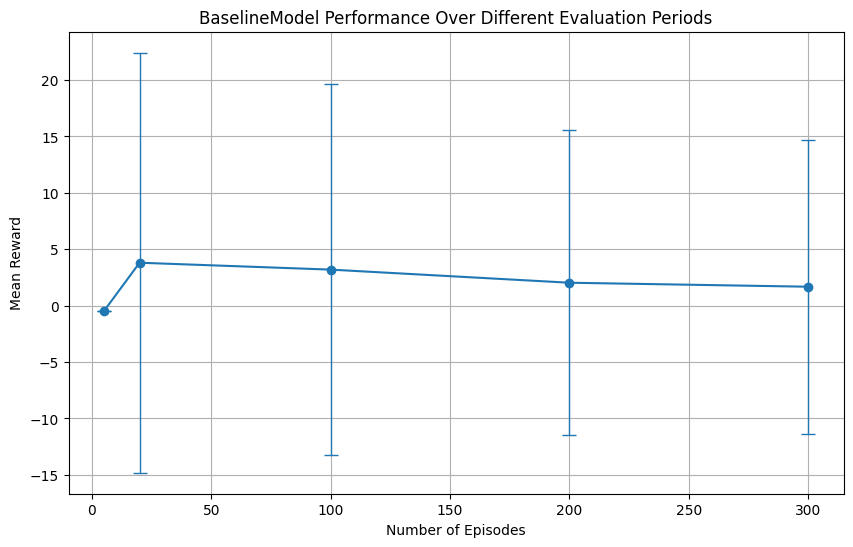

In [15]:
mean_rewards, std_rewards = evaluate_and_plot(model_baseline,'Baseline', env)

## 1st and 2nd Improvement(Reduced Observation Space and Action Space)

In [46]:
config = {
    "policy_type": "MlpPolicy",
    "total_timesteps": 1000,
    "env_name": "l2rpn_case14_sandbox",
}
run = wandb.init(
    project="RL_Final",
    config=config,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)


def make_env():
    env = Gym2OpEnvWrapper(use_rewards=False, baseline=False)
    env = Monitor(env)  # record stats such as returns
    return env


env = DummyVecEnv([make_env])
# env = VecVideoRecorder(
#     env,
#     f"videos/{run.id}",
#     record_video_trigger=lambda x: x % 2000 == 0,
#     video_length=200,
# )
model_DQN =DQN(config["policy_type"], env, verbose=1, tensorboard_log=f"runs/{run.id}")
model_DQN.learn(
    total_timesteps=config["total_timesteps"],
    callback=WandbCallback(
        gradient_save_freq=1,
        model_save_path=f"DQN_Final/{run.id}",
        verbose=1,
    ),
)
run.finish()
env.close()

/opt/conda/lib/python3.10/site-packages/grid2op/gym_compat/discrete_gym_actspace.py:260: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "redispatch" when building it, be aware that this continuous action will be treated as discrete by splitting it into bins. Consider using the "BoxGymActSpace" for these attributes.
  warnings.warn(
wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cuda device
Logging to runs/828q42tv/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.25     |
|    ep_rew_mean      | 0.145    |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 20       |
|    time_elapsed     | 0        |
|    total_timesteps  | 17       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 0.144    |
|    exploration_rate | 0.971    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 21       |
|    time_elapsed     | 1        |
|    total_timesteps  | 31       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.92     |
|    ep_rew_mean      | 0.205    |
|    exploration_rate | 0.955    |
| time

global_step,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█
rollout/ep_len_mean,▃▅▅▅▄▅▂▂▄▅▂▇██▄▂▂▅▆▆▆▇▃▂▁▂▄██▇▆▆▃▅▅▆▁▂▃▄
rollout/ep_rew_mean,▃▆▅▄▃▃▂▂▃▂▃▂▃▇▇▂▂█▄▂▄▅▆▇▆▄▃▃▃▇▅▆▆▆▆▅▁█▆▇
rollout/exploration_rate,█▅▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/fps,█▅▅▅█▅▅▅▅▅▅▅▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
global_step,9978
rollout/ep_len_mean,3.76
rollout/ep_rew_mean,0.21496
rollout/exploration_rate,0.05
time/fps,23


### DQN evaluation

In [35]:
env = Gym2OpEnvWrapper(use_rewards=False, baseline=False)
evaluate_policy(model_DQN, env, n_eval_episodes=200, render=False)


/opt/conda/lib/python3.10/site-packages/grid2op/gym_compat/discrete_gym_actspace.py:260: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "redispatch" when building it, be aware that this continuous action will be treated as discrete by splitting it into bins. Consider using the "BoxGymActSpace" for these attributes.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(351.8638130298711, 312.16003497298726)

In [ ]:
env.close()

In [ ]:
mean_rewards, std_rewards=evaluate_and_plot(model_DQN,'DQN Observation and Space Selection', env)

In [ ]:
mean_rewards, std_rewards

## DQN Replay Buffer

In [41]:
config = {
    "policy_type": "MlpPolicy",
    "total_timesteps": 1000,
    "env_name": "l2rpn_case14_sandbox",
}
run = wandb.init(
    project="RL_Final",
    config=config,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)


def make_env():
    env = Gym2OpEnvWrapper(use_rewards=False, baseline=False)
    env = Monitor(env)  # record stats such as returns
    return env


env = DummyVecEnv([make_env])
model_DQN_replay_buffer = DQN(config["policy_type"], env, verbose=1, tensorboard_log=f"runs/{run.id}",replay_buffer_class=ReplayBuffer)
model_DQN_replay_buffer.learn(
     total_timesteps=config["total_timesteps"],
     callback=WandbCallback(
         gradient_save_freq=1,
         model_save_path=f"DQN_Final/{run.id}",
         verbose=1,
     ),
 )
run.finish()
env.close()

/opt/conda/lib/python3.10/site-packages/grid2op/gym_compat/discrete_gym_actspace.py:260: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "redispatch" when building it, be aware that this continuous action will be treated as discrete by splitting it into bins. Consider using the "BoxGymActSpace" for these attributes.
  warnings.warn(
wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cuda device
Logging to runs/svvbqur1/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3        |
|    ep_rew_mean      | -0.0947  |
|    exploration_rate | 0.989    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 15       |
|    time_elapsed     | 0        |
|    total_timesteps  | 12       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.88     |
|    ep_rew_mean      | 0.253    |
|    exploration_rate | 0.971    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 21       |
|    time_elapsed     | 1        |
|    total_timesteps  | 31       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.08     |
|    ep_rew_mean      | 0.305    |
|    exploration_rate | 0.953    |
| time

global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█
rollout/ep_len_mean,█▇▅▄▅▃▇▆▅▅▅▁▃▃▂▃▅▄▄▄▄▃▃▂▂▁▆▅▅▇▄▄▄▅▃▃▄▂▄▄
rollout/ep_rew_mean,█▇▇▃▄▂▄▂▇██▆▁▁▃▁▆▃▄▄▂▁▁▄▅▃▂▂▄▆▃▅▃▃▅▄▃▄▂▃
rollout/exploration_rate,█▅▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/fps,▁▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
global_step,9992
rollout/ep_len_mean,3.43
rollout/ep_rew_mean,0.15022
rollout/exploration_rate,0.05
time/fps,23


In [42]:
env = Gym2OpEnvWrapper(use_rewards=False, baseline=False)
evaluate_policy(model_DQN_replay_buffer, env, n_eval_episodes=200, render=False)


/opt/conda/lib/python3.10/site-packages/grid2op/gym_compat/discrete_gym_actspace.py:260: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "redispatch" when building it, be aware that this continuous action will be treated as discrete by splitting it into bins. Consider using the "BoxGymActSpace" for these attributes.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(76.63106885164976, 157.49863740765878)

In [ ]:
env.close()

In [ ]:
env = Gym2OpEnvWrapper(use_rewards=False, baseline=False)
mean_rewards, std_rewards=evaluate_and_plot(model_DQN_replay_buffer,'Replay_Buffer' env)

In [ ]:
mean_rewards, std_rewards

In [ ]:
env.close()

## Tweaking Of Rewards with DQN Replay Buffer

In [ ]:

config = {
    "policy_type": "MlpPolicy",
    "total_timesteps": 1000,
    "env_name": "l2rpn_case14_sandbox",
}
run = wandb.init(
    project="RL_Final",
    config=config,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)


def make_env():
    env = Gym2OpEnvWrapper(training=True, baseline=False, other_rewards={"linesreconnected": LinesReconnectedReward,'linescapacity': LinesCapacityReward,
                                          'closetoOverflow':CloseToOverflowReward, 'alert':AlertReward})
    env = Monitor(env)  # record stats such as returns
    return env


env = DummyVecEnv([make_env])
model_replay_buffer_reward = DQN(config["policy_type"], env, verbose=1, tensorboard_log=f"runs/{run.id}", replay_buffer_class=ReplayBuffer)
model_replay_buffer_reward.learn(
     total_timesteps=config["total_timesteps"],
     callback=WandbCallback(
         gradient_save_freq=1,
         model_save_path=f"DQN_Final/{run.id}",
         verbose=1,
     ),
 )
run.finish()
env.close()

In [ ]:
env = Gym2OpEnvWrapper(training=False, baseline=False)
evaluate_policy(model_replay_buffer_reward, env, n_eval_episodes=200, render=False)


In [ ]:
env.close()

In [1]:
mean_rewards, std_rewards=evaluate_and_plot(model_replay_buffer_reward,'Replay Buffer Tweaked Rewards' env)

NameError: name 'evaluate_and_plot' is not defined

In [ ]:
mean_rewards, std_rewards

## DQN Target Network without tweaked rewards

In [36]:

config = {
    "policy_type": "MlpPolicy",
    "total_timesteps": 10000,
    "env_name": "l2rpn_case14_sandbox",
}
run = wandb.init(
    project="RL_Final",
    config=config,
    sync_tensorboard=True,  # auto-upload sb3's tensorboard metrics
    monitor_gym=True,  # auto-upload the videos of agents playing the game
    save_code=True,  # optional
)


def make_env():
    env = Gym2OpEnvWrapper(use_rewards=False, baseline=False,other_rewards={"linesreconnected": LinesReconnectedReward,'linescapacity': LinesCapacityReward,
                                          'closetoOverflow':CloseToOverflowReward, 'alert':AlertReward})
    env = Monitor(env)  # record stats such as returns
    return env


env = DummyVecEnv([make_env])
model_DQN_Target = DQN(config["policy_type"], env, verbose=1, tensorboard_log=f"runs/{run.id}",
    batch_size=256,
    tau=1.0,
    gamma=0.99,
    learning_starts = 100                 
    train_freq=4,
    gradient_steps=1,
    target_update_interval=500,
    exploration_fraction=0.2,
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05,
    max_grad_norm=10)

model_DQN_Target.learn(
    total_timesteps=config["total_timesteps"],
    callback=WandbCallback(
        gradient_save_freq=1,
        model_save_path=f"DQN_Final/{run.id}",
        verbose=1,
    ),
)
run.finish()
env.close()

/opt/conda/lib/python3.10/site-packages/grid2op/gym_compat/discrete_gym_actspace.py:260: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "redispatch" when building it, be aware that this continuous action will be treated as discrete by splitting it into bins. Consider using the "BoxGymActSpace" for these attributes.
  warnings.warn(
wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`


Using cuda device
Logging to runs/ciwlhrg9/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.25     |
|    ep_rew_mean      | 0.124    |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 20       |
|    time_elapsed     | 0        |
|    total_timesteps  | 17       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 0.159    |
|    exploration_rate | 0.992    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 20       |
|    time_elapsed     | 1        |
|    total_timesteps  | 32       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.42     |
|    ep_rew_mean      | 0.0634   |
|    exploration_rate | 0.99     |
| time

global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
rollout/ep_len_mean,▂▄▄▅▄▆▄▂▅▄▁▆▇▃▃▄▅▆▄▂▃▅▅▅▅▄▄▃▃▃▅▆▅██▅▅▅▃▃
rollout/ep_rew_mean,▁▇▂▆▄▄▄▄▅▃▄▅█▄▇▄▂▆▅▆▅▃▂▁▄▃▅▇▅█▄▄▄▆▅▅▅▄▄▇
rollout/exploration_rate,█▇▆▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/fps,▁▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆██████
global_step,19996
rollout/ep_len_mean,3.85
rollout/ep_rew_mean,0.28534
rollout/exploration_rate,0.05
time/fps,23


In [40]:
env = Gym2OpEnvWrapper(use_rewards=False, baseline=False)
evaluate_policy(model_DQN_Target, env, n_eval_episodes=200, render=False)


/opt/conda/lib/python3.10/site-packages/grid2op/gym_compat/discrete_gym_actspace.py:260: UserWarning: The class "DiscreteActSpace" should mainly be used to consider only discrete actions (eg. set_line_status, set_bus or change_bus). Though it is possible to use "redispatch" when building it, be aware that this continuous action will be treated as discrete by splitting it into bins. Consider using the "BoxGymActSpace" for these attributes.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(0.15598897667601705, 1.295463289616121)

In [ ]:
env.close()

In [ ]:
mean_rewards, std_rewards=evaluate_and_plot(model_DQN_Target,"Target Network" env)